In [92]:
# Recurrence analysis code example, Joaquin Gonzalez 2021, joaqgonzar@gmail.com

# load packages employed 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

In [133]:
# define recurrence plot function and its quantifications


def recurrence_plot(high_dim_series,threshold):
    
    recurrence_matrix = []
    distance_matrix = []
    
    for x in range(high_dim_series.shape[1]):
        dist = np.linalg.norm(high_dim_series[:,x]-high_dim_series[:,:].T,axis = 1, ord = 1)
        distance_matrix.append(dist)

    distance_matrix = np.array(distance_matrix)
    recurrence_matrix = np.where(distance_matrix>threshold,0,1)
    return(recurrence_matrix)



def recurrence_rate(recurrence_matrix):
        
    RR = np.sum(recurrence_matrix)/recurrence_matrix.shape[0]**2

    return RR


def rqa_diagonal(recurrence_matrix):
    
    # get diagonal elements
    
    diag_lenght = []
    divergence = []
    determinism = []
    
    for x in range(recurrence_matrix.shape[0]):
        diag_1 = np.diag(recurrence_matrix,k = x)
        diag_2 = np.diag(recurrence_matrix,k = recurrence_matrix.shape[0] - x)
        diag_elems = np.hstack((diag_1,diag_2))
        diag_ext = np.hstack((0,diag_elems,0))
        diffs = np.diff(diag_ext.astype(int))
        starts = np.argwhere(diffs == 1)
        stops = np.argwhere(diffs == -1)
        diag_lenght.append(stops-starts)
    
    diag_lenght = np.array(diag_lenght,dtype = 'object')
    diag_lenght = np.concatenate(diag_lenght)    
    diag_lenght = np.delete(diag_lenght, np.where(diag_lenght == recurrence_matrix.shape[0])) # eliminate main diagonal
    
    # get divergence and determiniscm    
    if diag_lenght.size != 0:    
        divergence = 1/np.max(diag_lenght)   
        diag_probs, diag_lenghts = np.histogram(diag_lenght,bins = np.arange(1,diag_lenght.max()+2),density = True)
        
        num =  np.sum(diag_probs[1:]*diag_lenghts[1:-1])
        den = np.sum(diag_probs*diag_lenghts[:-1])
        
        if den != 0:
            determinism = num/den
    
    return(divergence,determinism)


def rqa_vertical(recurrence_matrix):
    
    # get vertical elements
    
    vert_lenght = []
    trapping_time = []
    laminarity = []
    
    for x in range(recurrence_matrix.shape[0]):
        vert_elems = recurrence_matrix[:,x]
        vert_ext = np.hstack((0,vert_elems,0))
        diffs = np.diff(vert_ext.astype(int))
        starts = np.argwhere(diffs == 1)
        stops = np.argwhere(diffs == -1)
        vert_lenght.append(stops-starts)
    
    vert_lenght = np.array(vert_lenght,dtype = 'object')
    vert_lenght = np.concatenate(vert_lenght)    
    
    if vert_lenght.size != 0: 
        vert_probs, vert_lenghts = np.histogram(vert_lenght,bins = np.arange(1,vert_lenght.max()+2),density = True)
        
        num_lam =  np.sum(vert_probs[1:]*vert_lenghts[1:-1])
        den_lam = np.sum(vert_probs*vert_lenghts[:-1])
        
        if den_lam != 0:
            laminarity = num_lam/den_lam
            
        den_tt = np.sum(vert_probs[1:])
        
        if den_tt != 0:
            trapping_time = num_lam/den_tt
        
    
    return(trapping_time,laminarity)


def rqa(recurrence_plot):
    
    rr = recurrence_rate(recurrence_plot)
    divergence,determinism = rqa_diagonal(recurrence_plot)
    trapping_time,laminarity = rqa_vertical(recurrence_plot)
    
    return(rr,divergence,determinism,trapping_time,laminarity)




In [91]:
# compute 3 simple examples: harmonic oscillator, random data and Lorenx system

t = np.linspace(0,4,1000)

# sines with different frequencies
sine1 = np.sin(2*np.pi*5*t)    
sine2 = np.sin(2*np.pi*4.5*t)    

# random data from uniform (0,1) distribution
noise = np.random.rand(2,1000)

# chaotic data from Lorenz system (code obtained from:
# https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html)

def lorenz(x, y, z, s=10, r=28, b=2.667):
    
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)





In [94]:
# compute recurrence plots using the defined function

recurrence_matrix_chaos = recurrence_plot(np.array([xs,ys]),threshold = 5)
recurrence_matrix_sines = recurrence_plot(np.array([sine1,sine2]),threshold = 0.5)
recurrence_matrix_rand = recurrence_plot(np.array(noise),threshold = 0.2)

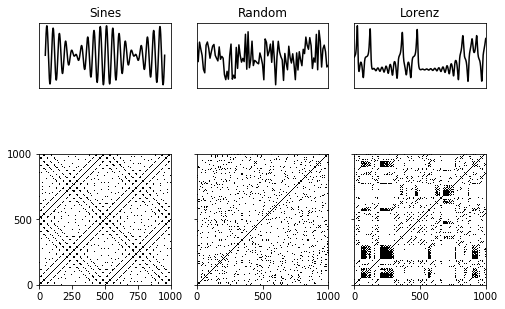

In [95]:
# plot examples

fig = plt.figure(figsize = (8,6))
gs = gridspec.GridSpec(2, 3, height_ratios=[1,4],hspace = 0.01)

plt.subplot(gs[0])
plt.plot(sine1+sine2,color = 'black')
plt.xticks([])
plt.yticks([])
plt.title('Sines')

plt.subplot(gs[1])
plt.plot(noise[0,:]+noise[1,:],color = 'black')
plt.xticks([])
plt.yticks([])
plt.xlim(0,100)
plt.title('Random')

plt.subplot(gs[2])
plt.plot(xs,color = 'black')
plt.xticks([])
plt.yticks([])
plt.xlim(0,2000)
plt.title('Lorenz')


plt.subplot(gs[3])

plt.imshow(recurrence_matrix_sines,'Greys',vmin = 0, vmax = 1)
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.yticks([0,500,1000],[0,500,1000])

plt.subplot(gs[4])
plt.imshow(recurrence_matrix_rand,'Greys',vmin = 0, vmax = 1)

plt.ylim(0,1000)
plt.xlim(0,1000)
plt.yticks([0,500,1000],[])
plt.xticks([0,500,1000],[0,500,1000])

plt.subplot(gs[5])
plt.imshow(recurrence_matrix_chaos,'Greys',vmin = 0, vmax = 1)

plt.ylim(0,5000)
plt.xlim(0,5000)
plt.yticks(ticks = [0,2500,5000],labels = [])
plt.xticks(ticks = [0,2500,5000],labels = [0,500,1000])


fig.align_ylabels()

Recurrence Rate: 0.012656
Determinism: 0.9933366238894374
Laminarity: 0.0
Divergence: 0.0005128205128205128


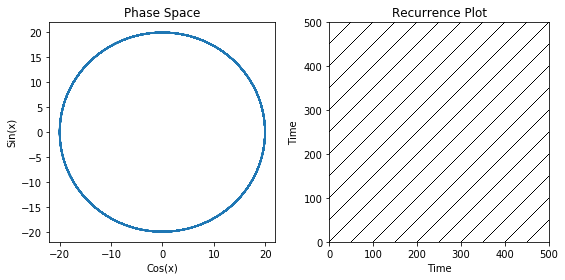

In [138]:
# compare rqa metrics between different systems
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 


# harmonic oscillator

t = np.linspace(0,4,2000)

# sines with different frequencies
sine = 20*np.sin(2*np.pi*10*t)    
cosine = 20*np.cos(2*np.pi*10*t)    

recurrence_matrix_sines = recurrence_plot(np.array([sine,cosine]),threshold = 1)
rr,divergence,determinism,trapping_time,laminarity = rqa(recurrence_matrix_sines)

plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(sine, cosine)
plt.title('Phase Space')
plt.ylabel('Sin(x)')
plt.xlabel('Cos(x)')


plt.subplot(122)
plt.imshow(recurrence_matrix_sines,'Greys',vmin = 0, vmax = 1)
plt.ylim(0,500)
plt.xlim(0,500)
plt.title('Recurrence Plot')
plt.ylabel('Time')
plt.xlabel('Time')

plt.tight_layout()

print('Recurrence Rate:',rr)
print('Determinism:',determinism)
print('Laminarity:',laminarity)
print('Divergence:',divergence)




Recurrence Rate: 0.02397576823782012
Determinism: 0.9953828804868189
Laminarity: 0.991614495984333
Divergence: 0.0016722408026755853


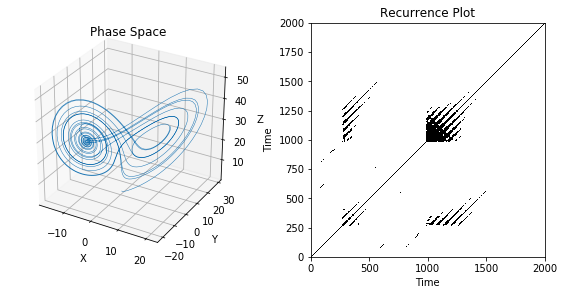

In [139]:
# chaotic Lorenz 

def lorenz(x, y, z, s=10, r=28, b=2.667):
    
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 2000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure(figsize = (8,4))

ax = fig.add_subplot(121,projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Phase Space")    

recurrence_matrix_chaos = recurrence_plot(np.array([xs,ys,zs]),threshold = 2)
rr,divergence,determinism,trapping_time,laminarity = rqa(recurrence_matrix_chaos)


ax = fig.add_subplot(122)
plt.imshow(recurrence_matrix_chaos,'Greys',vmin = 0, vmax = 1)

plt.ylim(0,num_steps)
plt.xlim(0,num_steps)
plt.title('Recurrence Plot')
plt.ylabel('Time')
plt.xlabel('Time')

plt.tight_layout()

print('Recurrence Rate:',rr)
print('Determinism:',determinism)
print('Laminarity:',laminarity)
print('Divergence:',divergence)


Recurrence Rate: 0.12226145797665884
Determinism: 0.9983467819680267
Laminarity: 0.9991277436751203
Divergence: 0.0005


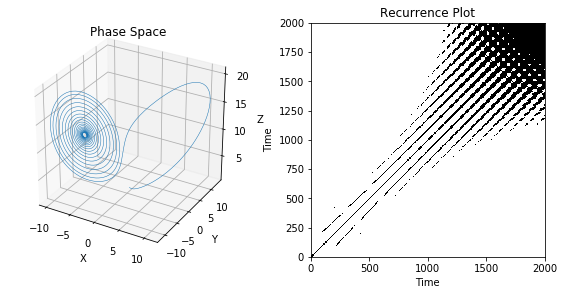

In [140]:
# non chaotic Lorenz

def lorenz(x, y, z, s=10, r=13, b=2.667):
    
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 2000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure(figsize = (8,4))

ax = fig.add_subplot(121,projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Phase Space")    

recurrence_matrix_chaos = recurrence_plot(np.array([xs,ys,zs]),threshold = 2)
rr,divergence,determinism,trapping_time,laminarity = rqa(recurrence_matrix_chaos)


ax = fig.add_subplot(122)
plt.imshow(recurrence_matrix_chaos,'Greys',vmin = 0, vmax = 1)

plt.ylim(0,num_steps)
plt.xlim(0,num_steps)
plt.title('Recurrence Plot')
plt.ylabel('Time')
plt.xlabel('Time')

plt.tight_layout()

print('Recurrence Rate:',rr)
print('Determinism:',determinism)
print('Laminarity:',laminarity)
print('Divergence:',divergence)